<a href="https://colab.research.google.com/github/Abrazacs/advanced_DL/blob/main/DL_CAPTCHA_NEW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

images = np.load('images.npy')
labels = np.load('labels.npy')

images = images.astype(np.float32)

images_train, images_test, labels_train, labels_test = train_test_split(
    images, labels, test_size=0.1, random_state=42
)

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

class LetterDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.images)

In [8]:
class LetterCNN(nn.Module):
    def __init__(self):
        super(LetterCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 26)
        )

    def forward(self, x):
        return self.model(x)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = LetterDataset(images_train, labels_train, transform=train_transform)
test_dataset = LetterDataset(images_test, labels_test, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

model = LetterCNN().to(device)
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.AdamW(model.parameters(), lr=0.0006, weight_decay=0.0001)

num_epochs = 200
train_losses, train_accuracies, test_accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total

    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_acc = test_correct / test_total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    test_accuracies.append(test_acc)

    print(f"[{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Test Acc: {test_acc:.4f}")

[1/200] Train Loss: 3.2483, Train Acc: 0.0468, Test Acc: 0.0465
[2/200] Train Loss: 3.1968, Train Acc: 0.0606, Test Acc: 0.0690
[3/200] Train Loss: 3.1265, Train Acc: 0.0809, Test Acc: 0.0815
[4/200] Train Loss: 3.0179, Train Acc: 0.1068, Test Acc: 0.1035
[5/200] Train Loss: 2.9534, Train Acc: 0.1238, Test Acc: 0.1395
[6/200] Train Loss: 2.8917, Train Acc: 0.1425, Test Acc: 0.1245
[7/200] Train Loss: 2.8152, Train Acc: 0.1674, Test Acc: 0.1875
[8/200] Train Loss: 2.7262, Train Acc: 0.1953, Test Acc: 0.1465
[9/200] Train Loss: 2.6421, Train Acc: 0.2166, Test Acc: 0.1260
[10/200] Train Loss: 2.5648, Train Acc: 0.2379, Test Acc: 0.1725
[11/200] Train Loss: 2.5085, Train Acc: 0.2584, Test Acc: 0.2700
[12/200] Train Loss: 2.4540, Train Acc: 0.2713, Test Acc: 0.2650
[13/200] Train Loss: 2.4021, Train Acc: 0.2932, Test Acc: 0.3110
[14/200] Train Loss: 2.3607, Train Acc: 0.3070, Test Acc: 0.2720
[15/200] Train Loss: 2.3058, Train Acc: 0.3297, Test Acc: 0.2905
[16/200] Train Loss: 2.2582, Train

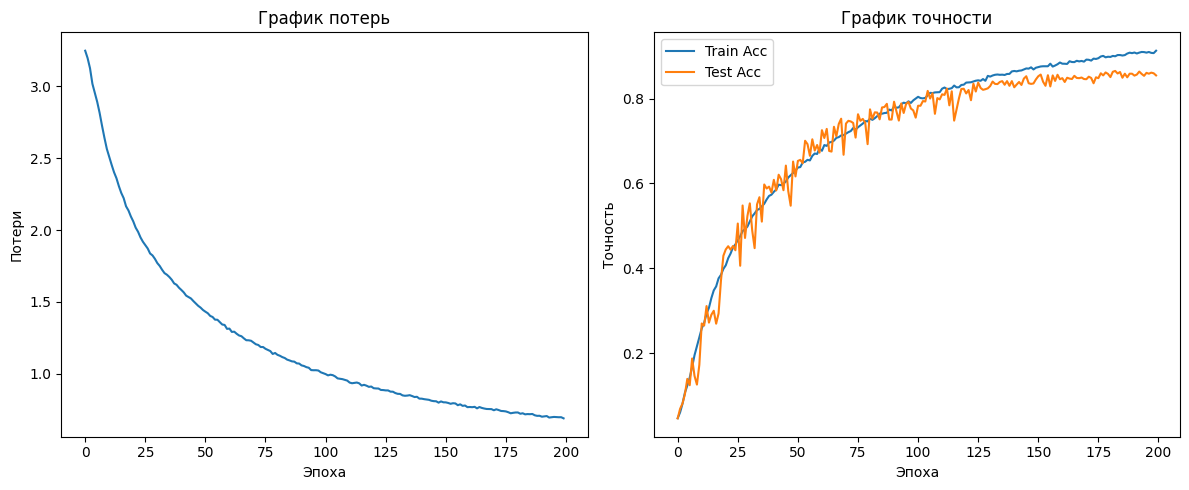

In [10]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.lineplot(x=range(num_epochs), y=train_losses)
plt.title("График потерь")
plt.xlabel("Эпоха")
plt.ylabel("Потери")

plt.subplot(1, 2, 2)
sns.lineplot(x=range(num_epochs), y=train_accuracies, label="Train Acc")
sns.lineplot(x=range(num_epochs), y=test_accuracies, label="Test Acc")
plt.title("График точности")
plt.xlabel("Эпоха")
plt.ylabel("Точность")
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
import pandas as pd
from torch.utils.data import TensorDataset

images_sub = np.load('images_sub.npy')
images_sub = images_sub / 255.0

img_sub_tensor = torch.from_numpy(images_sub).float().permute(0, 3, 1, 2).to(device)
sub_dataset = TensorDataset(img_sub_tensor)
sub_batch_size = 128
sub_dataloader = DataLoader(sub_dataset, batch_size=sub_batch_size, shuffle=False)

model.eval()
predictions = []
with torch.no_grad():
  for inputs in sub_dataloader:
    inputs = inputs[0].to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    predictions.extend(predicted.cpu().numpy())


submission_df = pd.DataFrame({'id': range(len(predictions)), 'category': predictions})
submission_df.to_csv('submission.csv', index=False)